In [1]:
import os
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from qiskit_optimization.applications import Tsp
from qiskit_algorithms import QAOA
from qiskit_algorithms.optimizers import COBYLA
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.primitives import Sampler
from qiskit import Aer
from tqdm import tqdm
import networkx as nx
import numpy as np
import math


### Data Preprocessing


In [2]:

data_dir = r'data\21_solving-vehicle-routing-problem-and-its-variants-using-quantum-computing_d-qint23_qross-Datasets-Result-Data-Synthetic-TSP'

dfs = []

csv_files = [os.path.join(root, file) for root, dirs, files in os.walk(data_dir) for file in files if file.endswith('.csv')]

for full_path in tqdm(csv_files, total=len(csv_files), bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt}'):
    df_file = pd.read_csv(full_path)
    dfs.append(df_file)
df = pd.concat(dfs, ignore_index=True)

100%|██████████| 85/85


In [3]:
df

,Relaxation Parameter A,Probability P_f,E_avg,E_std,E_min
0,4218.00,0.070312,66984.263871,4649.904420,53518.151014
1,4250.82,0.062500,66767.535234,4467.012351,54283.345921
2,4283.64,0.054688,67781.648134,4606.098256,56801.810406
3,4316.46,0.046875,67953.099510,4428.735985,57256.237944
4,4349.28,0.054688,67891.473254,4117.578820,57903.136557
...,...,...,...,...,...
8495,486.70,0.984375,5924.476759,523.608482,4500.360146
8496,489.36,1.000000,5970.642750,540.219575,4256.966468
8497,492.02,1.000000,5873.443450,495.450110,4645.787724
8498,494.68,1.000000,5979.712979,525.520594,4542.685017


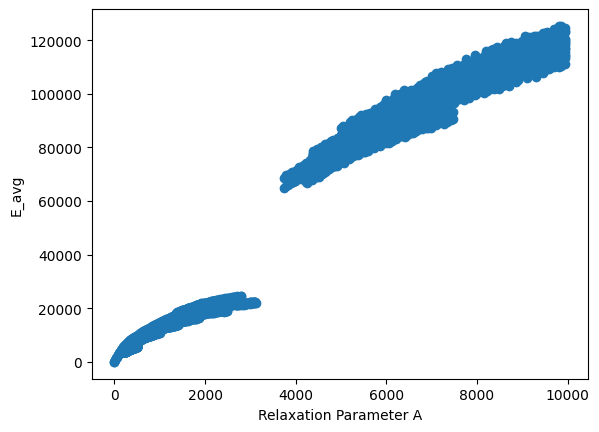

In [4]:
plt.scatter(df['Relaxation Parameter A'], df['E_avg'])
plt.xlabel('Relaxation Parameter A')
plt.ylabel('E_avg')
plt.show()

In [5]:
def validate_tsp_file(file_path):
    with open(file_path, 'r') as file:
        data = [line.strip() for line in file.readlines()]
    if not data:
        return False, "File is empty"
    dimension_line = [line for line in data if line.startswith('DIMENSION')]
    if not dimension_line:
        return False, "DIMENSION not found"
    
    dimension = int(dimension_line[0].split()[-1])
    start_index = data.index('NODE_COORD_SECTION') + 1
    city_lines = data[start_index:start_index+dimension]

    if dimension != len(city_lines):
        return False, f"DIMENSION {dimension} does not match the number of cities {len(city_lines)}"
    city_ids = [int(line.split()[0]) for line in city_lines]
    if city_ids != list(range(1, dimension + 1)):
        return False, "City IDs are not correct"
    return True, "TSP file is valid"

In [6]:
directory = "instances/instances/"

tsp_files = [os.path.join(directory, file) for file in os.listdir(directory) if file.endswith('.tsp')]

for tsp_file in tsp_files:
    is_valid, message = validate_tsp_file(tsp_file)
    print(f'File {tsp_file}: {message}')

File instances/instances/syn_tsp101.tsp: TSP file is valid
File instances/instances/syn_tsp102.tsp: TSP file is valid
File instances/instances/syn_tsp103.tsp: TSP file is valid
File instances/instances/syn_tsp104.tsp: TSP file is valid
File instances/instances/syn_tsp105.tsp: TSP file is valid
File instances/instances/syn_tsp106.tsp: TSP file is valid
File instances/instances/syn_tsp107.tsp: TSP file is valid
File instances/instances/syn_tsp108.tsp: TSP file is valid
File instances/instances/syn_tsp109.tsp: TSP file is valid
File instances/instances/syn_tsp110.tsp: TSP file is valid
File instances/instances/syn_tsp111.tsp: TSP file is valid
File instances/instances/syn_tsp112.tsp: TSP file is valid
File instances/instances/syn_tsp113.tsp: TSP file is valid
File instances/instances/syn_tsp114.tsp: TSP file is valid
File instances/instances/syn_tsp115.tsp: TSP file is valid
File instances/instances/syn_tsp116.tsp: TSP file is valid
File instances/instances/syn_tsp117.tsp: TSP file is val

In [7]:
def parse_tsp_data(file_path):
    with open(file_path, 'r') as file:
        data = file.read()
    lines = data.split('\n')
    dimension = int(lines[3].split()[-1])
    cities = {}
    for line in lines[6:6+dimension]:
        parts = line.split()
        cities[int(parts[0]) - 1] = (float(parts[1]), float(parts[2]))  

    G = nx.Graph()
    for i in cities:
        for j in cities:
            if i != j:
                dist = np.sqrt((cities[i][0] - cities[j][0])**2 + (cities[i][1] - cities[j][1])**2)
                G.add_edge(i, j, weight=dist)
    return G

100%|████████████████████| 85/85


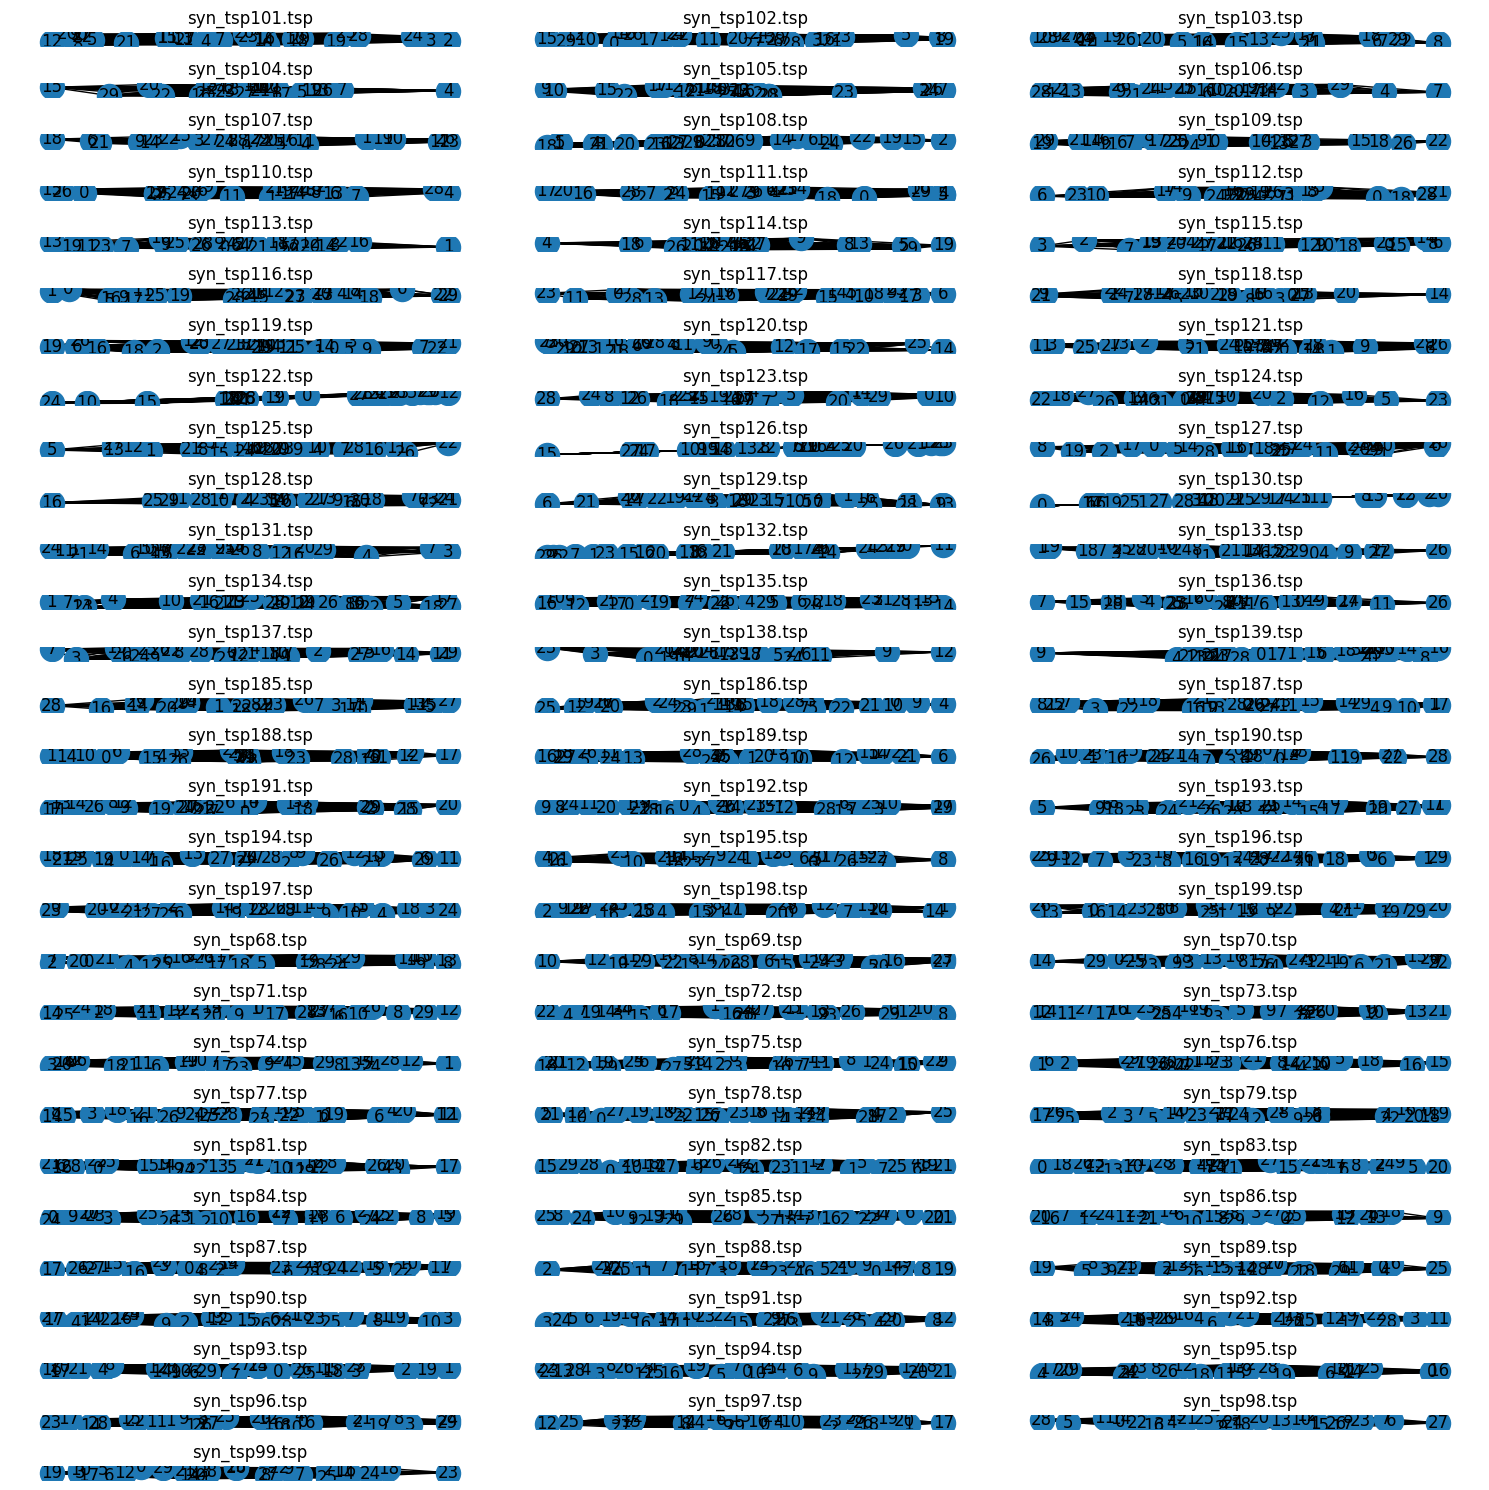

In [8]:
directory = "instances/instances/"

tsp_files = [f for f in os.listdir(directory) if f.endswith('.tsp')]

num_files = len(tsp_files)
cols = 3
rows = math.ceil(num_files / cols)

fig, axs = plt.subplots(rows, cols, figsize=(15, 15))

for i, tsp_file in tqdm(enumerate(tsp_files), total=len(tsp_files), bar_format='{l_bar}{bar:20}| {n_fmt}/{total_fmt}'):
    file_path = os.path.join(directory, tsp_file)
    G = parse_tsp_data(file_path)
    row = i // cols
    col = i % cols
    nx.draw(G, with_labels=True, ax=axs[row, col])
    axs[row, col].set_title(tsp_file)

for i in range(num_files, rows * cols):
    fig.delaxes(axs.flatten()[i])

plt.tight_layout()
plt.show()

### TSP using qiskit 

In [10]:
sampler = Sampler()
opt = COBYLA()
qaoa = QAOA(sampler, opt, reps=2)
optimizer = MinimumEigenOptimizer(qaoa)
all_results = {}
directory = "instances/instances/"
tsp_files = [f for f in os.listdir(directory) if f.endswith('.tsp')]
for tsp_file in tqdm(tsp_files, total=len(tsp_files), bar_format='{l_bar}{bar:20}| {n_fmt}/{total_fmt}'):
    file_path = os.path.join(directory, tsp_file)
    cities = parse_tsp_data(file_path)
    tsp = Tsp(cities)
    result = optimizer.solve(tsp.to_quadratic_program())
    all_results[tsp_file] = tsp.interpret(result)
for tsp_file, result in all_results.items():
    print(f"Solution for {tsp_file}: {result}")

C:\Users\hp\AppData\Local\Temp\ipykernel_19484\4009432403.py:5: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(optimizer=optimizer)


#### Save the result

In [ ]:
with open('results_tsp.txt', 'w') as f:
    for tsp_file, result in all_results.items():
        f.write(f"Solution for {tsp_file}: {result}\n")